# Foreground reconstruction on maps

## What is it here

* Reconstruction from CMB
* Reconstruction from foreground maps

In [18]:
import pathlib

import healpy as hp

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pathlib

from falafel import utils, qe

import solenspipe

import pytempura

import constants as const

from pixell import lensing, curvedsky

In [2]:
def gauss_beam(ell: np.ndarray, fwhm: float):
    '''
    Parameters
    ----------
    ell: np.ndarray
    fwhm: float, in arcmin

    Returns
    -------
    gauss_beam: np.ndarray
    '''
    tht_fwhm = np.deg2rad(fwhm / 60.)
    return np.exp(-(tht_fwhm**2.)*(ell**2.) / (16.*np.log(2.)))


def dummy_teb(alms):
    '''
    Creates a list of maps with the order [Tlm, Elm, Blm] and Elm, Blm = 0, 0
    '''
    return [alms, np.zeros_like(alms), np.zeros_like(alms)]

def filter_alms(alms, tcls, lmin, lmax):
    '''
    Takes input alms, and makes an isotropic filtering with tcls
    '''
    if len(alms)!=3:
        alms = dummy_teb(alms)
    alms_filtered = utils.isotropic_filter(alms,
            tcls, lmin, lmax, ignore_te = True)
    return alms_filtered


def fnu(nu, tcmb = const.default_tcmb):
    """
    nu in GHz
    tcmb in Kelvin
    """
    nu = np.asarray(nu)
    mu = const.H_CGS*(1e9*nu)/(const.K_CGS*tcmb)
    ans = mu/np.tanh(mu/2.0) - 4.0
    return ans

def tsz_factor_for_ymap(freq, tcmb = const.default_tcmb):
    return fnu(freq) * tcmb * 1e6

def process_tsz(comptony, freq, tcmb = const.default_tcmb):
    return tsz_factor_for_ymap(freq = freq, tcmb = tcmb) * comptony




### Some settings

In [3]:
mlmax = 6000

In [4]:
freq = 145

### Setting modes of reconstruction

In [5]:
kappa_lmin, kappa_lmax = 100, 3000

### Source maps

In [6]:
source_dir = pathlib.Path('/global/cscratch1/sd/omard/scatteringtfms/sims/')

In [7]:
kappa_name = 'healpix_4096_KappaeffLSStoCMBfullsky.fits'

cmb_name = 'Sehgalsimparams_healpix_4096_KappaeffLSStoCMBfullsky_phi_SimLens_Tsynfastnopell_fast_lmax8000_nside4096_interp2.5_method1_1_lensed_map.fits'

tsz_name = 'tSZ_skymap_healpix_nopell_Nside4096_y_tSZrescale0p75.fits'
ksz_name = '148_ksz_healpix_nopell_Nside4096_DeltaT_uK.fits'

mask_name = 'source_mask_145GHz.fits'

In [8]:
tsz_map = hp.read_map(source_dir/tsz_name)

maskf = hp.read_map(source_dir/mask_name)

tsz_map_masked = tsz_map*maskf

In [9]:
cmboutname = 'cmb'
kappaoutname = 'kappa'

nomi = [kappaoutname, cmboutname]
kappa_alm, cmb_alm = [hp.read_alm(source_dir/f'{nome}_alm.fits') for nome in nomi]

In [12]:
#tsz_map_alm = hp.map2alm(tsz_map)
#tsz_map_masked_alm = hp.map2alm(tsz_map_masked)

In [13]:
#np.save(source_dir/'tsz_map_alm', tsz_map_alm)
#np.save(source_dir/'tsz_map_masked_alm', tsz_map_masked_alm)

In [14]:
allelementstosave = np.load('input_cmb_145.npy')
ells, lcmb, tsz, ksz, radio, cib, dust, nl145, totalcmb, totalnoisecmb = allelementstosave.T

totalcmb_for_pol = lcmb+nl145 #just as temperature but no fg powere222e2eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeé        

In [15]:
nside = 4096

In [16]:
ell = np.arange(mlmax+1)

tot = np.interp(ell, ells, totalcmb)
totpol = np.interp(ell, ells, totalcmb_for_pol)

Nl_tt = np.nan_to_num(tot)

nells = {"TT": Nl_tt, "EE": 2*totpol, "BB": 2*totpol}

px = qe.pixelization(nside = nside)

ucls, tcls = utils.get_theory_dicts(grad = True, nells = nells, lmax = mlmax)

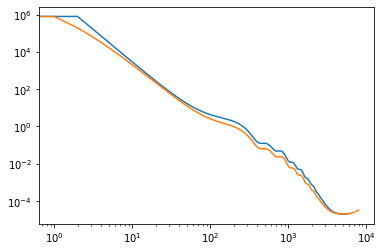

In [19]:
plt.loglog(tcls['TT'])
plt.loglog(totalcmb)
plt.show()

In [20]:


_, ls, Als, R_src_tt, Nl_g, Nl_c, Nl_g_bh = solenspipe.get_tempura_norms(
        est1 = 'TT', est2 = 'TT', ucls = ucls, tcls = tcls, lmin = kappa_lmin, lmax = kappa_lmax, mlmax = mlmax)

#R_src_tt = pytempura.get_cross('SRC', 'TT', ucls, tcls, kappa_lmin, kappa_lmax, k_ellmax = mlmax)

norm_stuff = {"ls": ls, "Als": Als, "R_src_tt": R_src_tt,
                  "Nl_g": Nl_g, "Nl_c": Nl_c, "Nl_g_bh": Nl_g_bh,
    }



 Response (TT)


In [21]:


qfunc = solenspipe.get_qfunc(px, ucls, mlmax, "TT", Al1 = Als['TT'])
qfunc_bh = solenspipe.get_qfunc(px, ucls, mlmax, "TT", est2 = 'SRC', Al1 = Als['TT'], 
                                Al2 = Als['src'], R12 = R_src_tt)

#qfunc2 = lambda X,Y: qe.qe_source(px, mlmax, fTalm=Y[0],xfTalm=X[0], profile = None)
#qfunc_shear = lambda X,Y: qe.qe_shear(px, mlmax, Talm = X[0], fTalm = Y[0])



In [22]:
maps = [cmb_alm, process_tsz(tsz_map_alm, freq), process_tsz(tsz_map_masked_alm, freq)]

codes = ['', 'tsz', 'tsz_masked']

all_spectra = {}

for map_alm, code in zip(maps, codes):
    input_alm = utils.change_alm_lmax(map_alm, mlmax)
    input_alm_filtered = filter_alms(map_alm, tcls, kappa_lmin, kappa_lmax)

    versions = ['qe']#, 'bh'] 
    functions = [qfunc, qfunc_bh]

    for function, version in zip(functions, versions):

        stuff = {}

        phi_recon_alms = function(input_alm_filtered, input_alm_filtered)
        kappa_recon_alms = lensing.phi_to_kappa(phi_recon_alms)

        cl_kk_output_output = curvedsky.alm2cl(kappa_recon_alms[0])
        cl_kk_input_output = curvedsky.alm2cl(kappa_recon_alms[0], kappa_alm)
        cl_kk_input = curvedsky.alm2cl(kappa_alm)

        np.save(source_dir/f'kappa_reconstructed_{version}{code}', kappa_recon_alms[0])

        stuff['oo'] = cl_kk_output_output
        stuff['io'] = cl_kk_input_output
        stuff['ii'] = cl_kk_input

    all_spectra[code] = stuff



: 

: 

In [ ]:

plt.loglog(cl_kk_input_output, label = '$\hat{\kappa}\kappa$')
plt.loglog(cl_kk_input, label = '$\kappa\kappa$')
plt.legend()
#plt.savefig(f'reconstruction_{version}.png')
plt.show()